In [23]:
from __future__ import print_function
import argparse
import torch
import torch.utils.data
from torch import nn, optim
from torch.nn import functional as F
from torchvision import datasets, transforms
from torchvision.utils import save_image
import numpy as np

"""
parser = argparse.ArgumentParser(description='VAE MNIST Example')
parser.add_argument('--batch-size', type=int, default=128, metavar='N',
                    help='input batch size for training (default: 128)')
parser.add_argument('--epochs', type=int, default=10, metavar='N',
                    help='number of epochs to train (default: 10)')
parser.add_argument('--no-cuda', action='store_true', default=False,
                    help='enables CUDA training')
parser.add_argument('--seed', type=int, default=1, metavar='S',
                    help='random seed (default: 1)')
parser.add_argument('--log-interval', type=int, default=10, metavar='N',
                    help='how many batches to wait before logging training status')
args = parser.parse_args()
args.cuda = not args.no_cuda and torch.cuda.is_available()
"""
batch_size = 128
seed = 1
epochs = 300
cuda = True
log_interval = 10
h_d = 512
l_d = 32
u_d = 1



torch.manual_seed(seed)

### Preparing for the dataset

In [2]:
#hmnist dataset
import healing_mnist_penalty

In [3]:
hmnist = healing_mnist_penalty.HealingMNIST(seq_len=5, # 5 rotations of each digit
                                          square_count=0, # 3 out of 5 images have a square added to them
                                          square_size=5, # the square is 5x5
                                          noise_ratio=0.1, # on average, 20% of the image is eaten by noise,
                                          digits=range(10), # only include this digits
                                          test = False,
                                          lag = 0.3
                                         )

In [4]:
print(hmnist.train_images.shape,hmnist.train_targets.shape)
print(hmnist.train_rotations.shape)
print(hmnist.test_images.shape,hmnist.test_targets.shape)
print(hmnist.test_rotations.shape)

(60000, 5, 28, 28) (60000, 5, 28, 28)
(60000, 5)
(10000, 5, 28, 28) (10000, 5, 28, 28)
(10000, 5)


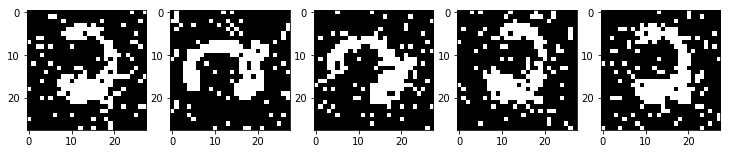

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline
case = 258
fig = plt.figure(figsize=(15,8))
for i, image in enumerate(hmnist.test_images[case]):
    fig.add_subplot(1, 6, i+1)
    plt.imshow(image,cmap='gray')
    

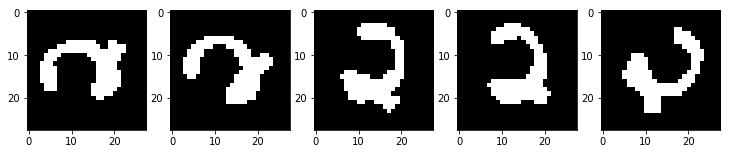

In [6]:
fig = plt.figure(figsize=(15,8))
for i, image in enumerate(hmnist.test_targets[case]):
    fig.add_subplot(1, 6, i+1)
    plt.imshow(image,cmap='gray')

In [7]:
print(hmnist.test_rotations[case])

[ 89.09822559 -50.60935964 -61.63704093  35.49038145 -68.77736686]


### Adjust the data shape
this part should be different for different model, the q-INDEP model completely igorned the sequencial dependency within the dataset, so we will flat the dataset in a way that given a noisy image $p$ and an action $u$, the target should be the image de-noised and then rotate angle $u$

In [24]:
train_X = hmnist.train_images
train_u = hmnist.train_rotations
train_Y = hmnist.train_targets
test_X = hmnist.test_images
test_u = hmnist.test_rotations
test_Y = hmnist.test_targets
print(train_X.shape,train_u.shape,train_Y.shape)
print(test_X.shape,test_u.shape,test_Y.shape)

(60000, 5, 28, 28) (60000, 5) (60000, 5, 28, 28)
(10000, 5, 28, 28) (10000, 5) (10000, 5, 28, 28)


In [25]:
#for the above six parameter, flaten the first two dimension
train_X = train_X.reshape(-1,28,28)
train_u = train_u.reshape(-1)
train_Y = train_Y.reshape(-1,28,28)
test_X = test_X.reshape(-1,28,28)
test_u = test_u.reshape(-1)
test_Y = test_Y.reshape(-1,28,28)
print(train_X.shape,train_u.shape,train_Y.shape)
print(test_X.shape,test_u.shape,test_Y.shape)

(300000, 28, 28) (300000,) (300000, 28, 28)
(50000, 28, 28) (50000,) (50000, 28, 28)


In [26]:
device = torch.device("cuda" if cuda else "cpu")

kwargs = {'num_workers': 0, 'pin_memory': True} if cuda else {}

### Dataset object

In [27]:
class HMNISTDataSet():
    def __init__(self, train_img, train_act, train_tar, test_img, test_act, test_tar, test = False, transform=None):
        self.test = test
        self.transform = transform

        if (self.test == False):
          self.images = train_img
          self.targets = train_tar
          self.rotations = train_act

        else:      
          self.images = test_img
          self.targets = test_tar
          self.rotations = test_act

    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, index):
        if self.transform is not None:
            img = self.transform(self.images[index].reshape(28,28,1))
            tar = self.transform(self.targets[index].reshape(28,28,1))
            rot = torch.tensor(self.rotations[index])
        return img, rot, tar

In [28]:
train_set = HMNISTDataSet(train_X, train_u, train_Y, test_X, test_u, test_Y, test = False, transform = transforms.ToTensor())
test_set = HMNISTDataSet(train_X, train_u, train_Y, test_X, test_u, test_Y, test = True, transform = transforms.ToTensor())

### Create DataLoader

In [29]:
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=True, **kwargs)

### Model definition

In [30]:
class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()

        self.fc1 = nn.Linear(784, h_d)
        self.fc2 = nn.Linear(h_d,128)
        self.fc21 = nn.Linear(128, l_d)
        self.fc22 = nn.Linear(128, l_d)
        
        #transition layer
        self.fct = nn.Linear(l_d + u_d, l_d)
        self.fctm = nn.Linear(l_d,l_d)
        self.fcts = nn.Linear(l_d,l_d)
        
        self.fc3 = nn.Linear(l_d, 128)
        self.fc4 = nn.Linear(128,h_d)
        self.fc5 = nn.Linear(h_d, 784)
        
    def encode(self, x):
        x = x.float()
        h1 = F.relu(self.fc1(x))
        h2 = F.relu(self.fc2(h1))
        return self.fc21(h2), self.fc22(h2)

    def reparameterize1(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std
    
    def transition(self, z, u):
        h2 = F.relu(self.fct(torch.cat((z,u),dim=1)))
        return self.fctm(h2), self.fcts(h2)
    
    def reparameterize2(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std

    def decode(self, z):
        h3 = F.relu(self.fc3(z))
        h4 = F.relu(self.fc4(h3))
        return torch.sigmoid(self.fc5(h4))

    def forward(self, x, u):
        mu1, logvar1 = self.encode(x.view(-1, 784))
        z1 = self.reparameterize1(mu1, logvar1)
        mu2, logvar2 = self.transition(z1,u.reshape(-1,1))
        z2 = self.reparameterize2(mu2, logvar2)
        
        return self.decode(z2), mu2, logvar2

In [31]:
model = VAE().to(device)
#adam optimizer
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [32]:
# Reconstruction + KL divergence losses summed over all elements and batch
def loss_function(recon_x, x, mu, logvar):
    x = x.float()
    BCE = F.binary_cross_entropy(recon_x, x.view(-1, 784), reduction='sum')

    # see Appendix B from VAE paper:
    # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
    # https://arxiv.org/abs/1312.6114
    # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    return BCE + KLD

### Define training and testing algorithm

In [33]:
def train(epoch):
    model.train()
    train_loss = 0
    for batch_idx, (img, action, target) in enumerate(train_loader):
        img = img.to(device)
        action = action.to(device)
        target = target.to(device)
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(img,action)
        loss = loss_function(recon_batch, target, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
        #if batch_idx % log_interval == 0:
         #   print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
          #      epoch, batch_idx * len(img), len(train_loader.dataset),
           #     100. * batch_idx / len(train_loader),
            #    loss.item() / len(img)))

    print('====> Epoch: {} Average loss: {:.4f}'.format(
          epoch, train_loss / len(train_loader.dataset)))
    return train_loss / len(train_loader.dataset)

In [34]:
def test(epoch):
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for i, (img, action, target) in enumerate(test_loader):
            img = img.to(device)
            action = action.to(device)
            target = target.to(device)
            recon_batch, mu, logvar = model(img, action)
            test_loss += loss_function(recon_batch, target, mu, logvar).item()
            if(epoch > epochs-10):
                if i == 0:
                    n = min(img.size(0), 8)
                    comparison = torch.cat([target[:n].float(),
                                          recon_batch.view(batch_size, 1, 28, 28)[:n]])
                    save_image(comparison.cpu(),
                             'results_ind_lag/reconstruction_' + str(epoch) + '.png', nrow=n)

    test_loss /= len(test_loader.dataset)
    print('====> Test set loss: {:.4f}'.format(test_loss))
    return test_loss

### Run training

In [35]:
train_losses = []
test_losses = []
for epoch in range(1, epochs + 1):
    train_loss = train(epoch)
    test_loss = test(epoch)
    train_losses.append(train_loss)
    test_losses.append(test_loss)
    with torch.no_grad():
        if(epoch > epochs - 10):
            sample = torch.randn(64, l_d).to(device)
            sample = model.decode(sample).cpu()
            save_image(sample.view(64, 1, 28, 28),
                       'results_ind_lag/sample_' + str(epoch) + '.png')


====> Epoch: 1 Average loss: 214.9962
====> Test set loss: 207.7991
====> Epoch: 2 Average loss: 204.9722
====> Test set loss: 202.5670
====> Epoch: 3 Average loss: 201.7095
====> Test set loss: 200.9987
====> Epoch: 4 Average loss: 200.9980
====> Test set loss: 200.3008
====> Epoch: 5 Average loss: 187.8663
====> Test set loss: 177.4612
====> Epoch: 6 Average loss: 175.2574
====> Test set loss: 173.3877
====> Epoch: 7 Average loss: 171.9327
====> Test set loss: 171.9852
====> Epoch: 8 Average loss: 169.8663
====> Test set loss: 171.3563
====> Epoch: 9 Average loss: 168.2610
====> Test set loss: 171.0710
====> Epoch: 10 Average loss: 166.8773
====> Test set loss: 170.8949
====> Epoch: 11 Average loss: 165.6235
====> Test set loss: 171.6687
====> Epoch: 12 Average loss: 164.5371
====> Test set loss: 171.2090
====> Epoch: 13 Average loss: 163.5210
====> Test set loss: 171.5193
====> Epoch: 14 Average loss: 162.5516
====> Test set loss: 171.6474
====> Epoch: 15 Average loss: 161.7263
====

RuntimeError: reduce failed to synchronize: cudaErrorAssert: device-side assert triggered

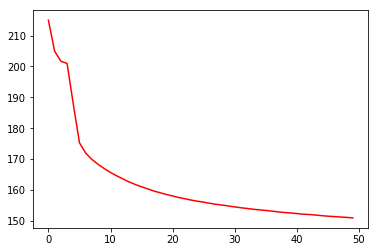

In [36]:
plt.plot(np.array(train_losses),'r')
plt.show()

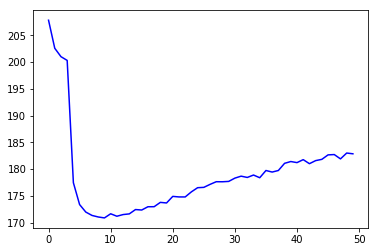

In [37]:
plt.plot(np.array(test_losses),'b')
plt.show()